# How fast can we go?

Q: I want to render a galaxy model, how quickly can I do this?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import numpy as np
import pandas as pd
import numba
from numba import jit
import matplotlib.pyplot as plt
from gzbuilderspirals import xy_from_r_theta
import lib.galaxy_utilities as gu
import lib.python_model_renderer.render_galaxy as rg
import lib.python_model_renderer.parse_annotation as pa

In [3]:
plt.style.use('seaborn-dark')

In [31]:
@jit(nopython=True, parallel=True)
def sersic_func(p, out=np.zeros((256, 256)), oversample_n=5):
    DX = np.linspace(
        0.5/oversample_n - 0.5,
        1 - 0.5 - 0.5/oversample_n,
        oversample_n
    )
    DY = np.linspace(
        0.5/oversample_n - 0.5,
        1 - 0.5 - 0.5/oversample_n,
        oversample_n
    )
    N = len(DX) * len(DY)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            for dx in DX:
                for dy in DY:
                    out[i, j] = rg.sersic2d(i, j, *p) / N
    return out

def to_p(comp):
  args = ('mu', 'roll', 'rEff', 'axRatio', 'c', 'i0', 'n')
  return tuple([comp[k] for k in args])

In [6]:
p_test = ((128.0, 128.0), np.pi/3, 20.0, .5, 2.0, 1.0, 1.0)
%timeit sersic_func(p_test)

21.9 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
th = np.linspace(1, 2*np.pi, 100)
r = np.exp(th * np.tan(np.deg2rad(20)))
r *= 90 / r.max()
poly_line = xy_from_r_theta(r, th).T + 128

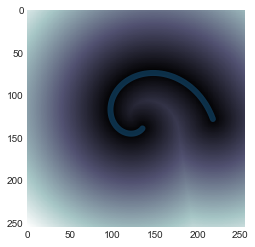

In [38]:
arm_distances = rg.spiral_distance_numba(poly_line)
plt.imshow(arm_distances, cmap='bone')
plt.plot(*poly_line.T, alpha=0.4, linewidth=6)

In [9]:
%timeit rg.spiral_distance_numba(poly_line)

15.1 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
cls = gu.classifications.query('user_name == "tingard"').iloc[-10]
subject_id = cls['subject_ids']

In [11]:
gal, angle = gu.get_galaxy_and_angle(subject_id)
psf = gu.get_psf(subject_id)
diff_data = gu.get_image_data(subject_id)
galaxy_data = np.array(diff_data['imageData'])[::-1]
pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
size_diff = diff_data['width'] / diff_data['imageWidth']
gal = gal.iloc[0]

In [12]:
ann = json.loads(cls['annotations'])
model = pa.parse_annotation(ann, size_diff)

In [13]:
def f():
    return [
        rg.spiral_distance_numba(a[0], np.zeros_like(galaxy_data))
        for a in model['spiral']
    ]
arm_distances = f()
%timeit f()

3.29 ms ± 87 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
p2 = to_p(model['disk'])
print(p, p2)
sersic_func(
    p2,
    out=np.zeros_like(galaxy_data),
    oversample_n=10
)

{'mu': array([61.82861328, 63.12084198]), 'roll': 0.21788764027567517, 'rEff': 34.42255320417607, 'axRatio': 0.5435468720506834, 'i0': 0.06, 'c': 2, 'n': 1}
((128.0, 128.0), 1.0471975511965976, 20.0, 0.5, 2.0, 1.0, 1.0) (array([61.82861328, 63.12084198]), 0.21788764027567517, 34.42255320417607, 0.5435468720506834, 2, 0.06, 1)


array([[1.50035635e-08, 1.70794826e-08, 1.94359365e-08, ...,
        2.71794574e-07, 2.41537908e-07, 2.14486804e-07],
       [1.58467031e-08, 1.80454599e-08, 2.05423512e-08, ...,
        2.79537138e-07, 2.48234707e-07, 2.20274297e-07],
       [1.67313356e-08, 1.90593494e-08, 2.17040819e-08, ...,
        2.87292539e-07, 2.54934174e-07, 2.26056884e-07],
       ...,
       [1.70808159e-07, 1.92875513e-07, 2.17648903e-07, ...,
        2.84580857e-08, 2.50131333e-08, 2.19772698e-08],
       [1.66656431e-07, 1.88059160e-07, 2.12065794e-07, ...,
        2.69099176e-08, 2.36609578e-08, 2.07966155e-08],
       [1.62492166e-07, 1.83234139e-07, 2.06479494e-07, ...,
        2.54370032e-08, 2.23739993e-08, 1.96724698e-08]])

In [33]:
foo = sersic_func(
    to_p(model['disk']),
    out=np.zeros_like(galaxy_data),
    oversample_n=10
)
foo2 = rg.sersic_comp(
    model['disk'],
    galaxy_data.shape[0],
    oversample_n=10
)

{'mu': array([61.82861328, 63.12084198]), 'roll': 0.21788764027567517, 'rEff': 34.42255320417607, 'axRatio': 0.5435468720506834, 'i0': 0.06, 'c': 2, 'n': 1}


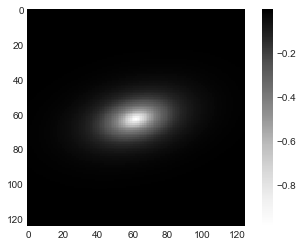

In [34]:
plt.imshow((foo - foo2) / np.abs(foo2).max())
plt.colorbar()

In [17]:
%timeit rg.calculate_model(model, galaxy_data.shape[0])

107 ms ± 9.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
